# A simple baseline CNN with improvements
Our baseline CNN has an accuracy of around 77%. Let's see if we can improve! We will test the following:
1. Data augmentation
2. Balance dataset
3. Dropout
4. Batch normalization
5. Weight decay
6. Learning rate scheduler
7. reduce model size by global average pooling

## import required libraries


In [1]:
import os
import sys
import torch
import torch.optim as optim
from torchinfo import summary


module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_transforms
from src.models import simplecnn
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate


## 1. Add data augmentation (accuracy 89%, + 13%)

In the previous notebook (03_simple_CNN.ipynb) we explored a simple CNN and trained it on the original dataset. The results showed that the model overfitted the original training dataset. To prevent this overfitting, lets try data augmentation.
 Data augmentation creates new training examples through applying small modifications to the original training images. Examples of such modifications are cropping, rotation, or flipping. Data augnmentation helps in similating slight variability in real world data, so that the model is able to generalize better on unseen data.

Data augmentation should only be applied to the training dataset and not to the validation and test set, because during validation and testing, we want to measure performance on data that resembles unaltered, realistic inputs.

In Pytorch, defining a dataset using torchvision.transforms, the augmentation is applied each time an image is loaded during training. Every epoch (and every batch) the model sees slightly different versions of the same training images. Thus, when the augmentation is applied, the number of training samples per epoch stays the same (namely the number of images in the original, un-augmented training set), but the model sees a slightly different version of each image every time it is loaded. As a result, the model sees more variety over multiple epochs. 

### Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 0.001
img_size = 224 # make smaller for faster CPU training
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


### Load data
Here we apply the data augmentation to the train dataset by setting augment to 'True' when retreiving the train transform. The data augmentation consists of the following steps:
- RandomHorizontalFlip(p=0.5): randomly flip the image with 50% probability. This represents variations in patient position
- RandomRotation(10): Randomly rotate the image in the range -10 to 10 degrees. This represents slight positioning differences during scanning.
- RandomResizedCrop(size,scale=(0.9,0.1)): randomply crop the image and resize it. This represents variablity in cropping or zooming level.
- ColorJitter(brightness=0.1, contrast=0.1): This represents variability in image acquisition, like exposure and contrast.

In [3]:
# set num_workers to 0, safer on Windows with CPU
train_transform = get_transforms(img_size,to_rgb=False,augment=True) # apply data augmentation
val_transform = get_transforms(img_size,to_rgb=False, augment=False)
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

### Model setup
#### Create instance of SimpleCNN model 

In [4]:
model_augment = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=False)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model_augment.parameters(), lr=learning_rate)

# print the model summary
summary(model_augment,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model


In [5]:
metrics_history= train_model(model_augment,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:27<00:00,  2.75s/it]


  Average train loss:0.265854  
 Accuracy on the train dataset: 89.05%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


  Average val loss:0.529129  
 Accuracy on the validation dataset: 78.21%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [06:13<00:00,  2.29s/it]


  Average train loss:0.143707  
 Accuracy on the train dataset: 94.94%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


  Average val loss:0.456772  
 Accuracy on the validation dataset: 86.22%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [06:13<00:00,  2.29s/it]


  Average train loss:0.112537  
 Accuracy on the train dataset: 95.84%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.384093  
 Accuracy on the validation dataset: 87.18%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [06:14<00:00,  2.30s/it]


  Average train loss:0.108729  
 Accuracy on the train dataset: 96.05%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


  Average val loss:0.442561  
 Accuracy on the validation dataset: 82.21%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [06:24<00:00,  2.36s/it]


  Average train loss:0.099934  
 Accuracy on the train dataset: 96.20%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.405458  
 Accuracy on the validation dataset: 87.18%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [06:08<00:00,  2.26s/it]


  Average train loss:0.098570  
 Accuracy on the train dataset: 96.09%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.444388  
 Accuracy on the validation dataset: 86.38%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [06:25<00:00,  2.36s/it]


  Average train loss:0.095424  
 Accuracy on the train dataset: 96.32%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.342431  
 Accuracy on the validation dataset: 88.46%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [06:00<00:00,  2.21s/it]


  Average train loss:0.082436  
 Accuracy on the train dataset: 96.74%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.426571  
 Accuracy on the validation dataset: 85.26%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [06:07<00:00,  2.26s/it]


  Average train loss:0.081237  
 Accuracy on the train dataset: 97.07%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


  Average val loss:0.452859  
 Accuracy on the validation dataset: 83.97%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [06:12<00:00,  2.29s/it]


  Average train loss:0.073906  
 Accuracy on the train dataset: 97.32%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

  Average val loss:0.547507  
 Accuracy on the validation dataset: 84.13%
Done!


### Save the model

In [6]:
torch.save(model_augment,'../models/simplecnn_dataaugment_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Accuracy on the test set: 84.13%
Precision: 0.81, Recall: 0.97, F1 score: 0.88, AUC: 0.80
classification_report :              precision    recall  f1-score   support

           0       0.92      0.63      0.75       234
           1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



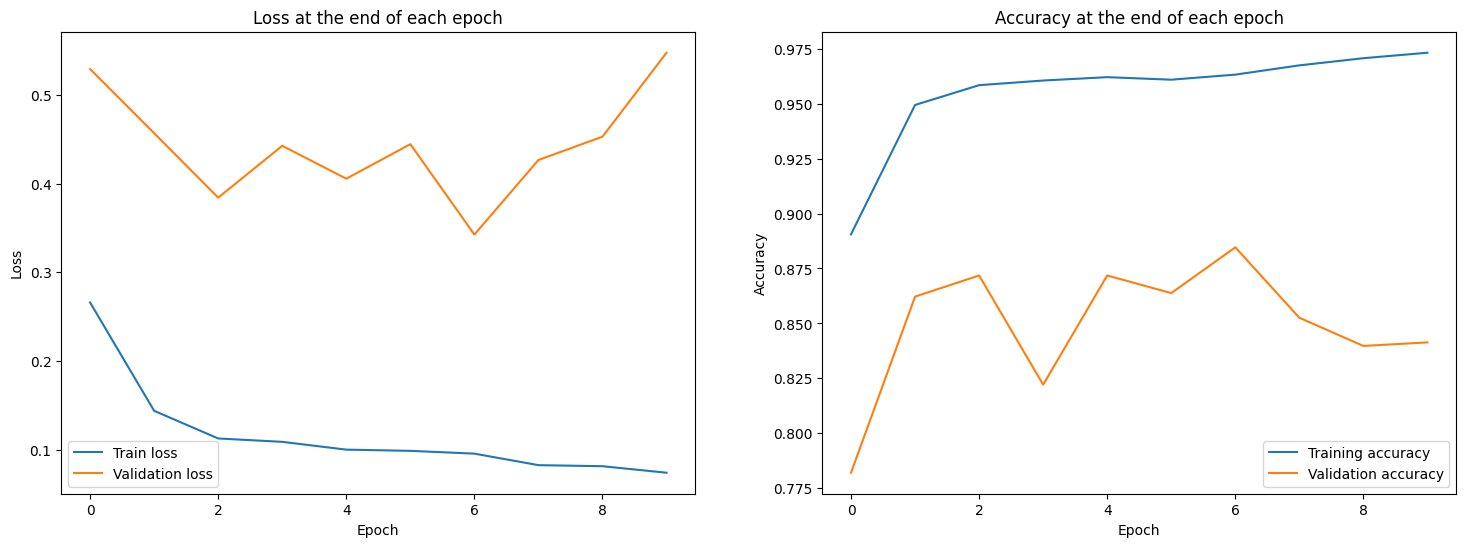

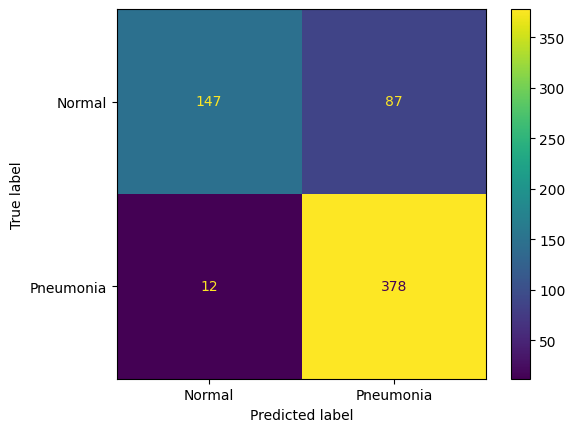

In [7]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_augment, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

### Conclusion
- Adding data augmentation to our training dataset has improved the model performance. The accuracy on the test dataset now is 89%. The F1 score is 0.92.

## 2. Balance the training dataset
The current training dataset is imbalanced, there are more pneumonia images than there are normal images. This can lead to a model that does not perform well on the under-represented class, i.e. the model becomes biased toward the majority class. This is also what we see in the confusion matrix, the model has more difficulty to correctly identify normal images (more false negatives than false positives, it predicts 'Pneumonia' too often).
Here we will use Pytorch's 'WeightedRandomSampler' to assign a higher probability to the minority class, so that both classes are seen equally during training.


### load data
Here we create a new train dataloader, that balances the dataset


In [8]:
balanced_train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)


### Model setup

In [9]:
model_balance = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=False)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model_balance.parameters(), lr=learning_rate)

# print the model summary
summary(model_balance,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model

In [10]:
metrics_history= train_model(model_balance,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:39<00:00,  2.82s/it]


  Average train loss:0.286184  
 Accuracy on the train dataset: 87.27%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


  Average val loss:0.348512  
 Accuracy on the validation dataset: 87.82%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:27<00:00,  2.75s/it]


  Average train loss:0.149281  
 Accuracy on the train dataset: 94.56%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


  Average val loss:0.326519  
 Accuracy on the validation dataset: 87.66%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:44<00:00,  2.85s/it]


  Average train loss:0.118630  
 Accuracy on the train dataset: 96.03%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


  Average val loss:0.344075  
 Accuracy on the validation dataset: 88.78%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:17<00:00,  2.69s/it]


  Average train loss:0.109157  
 Accuracy on the train dataset: 95.99%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


  Average val loss:0.381140  
 Accuracy on the validation dataset: 83.49%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:25<00:00,  2.74s/it]


  Average train loss:0.111825  
 Accuracy on the train dataset: 95.76%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.470571  
 Accuracy on the validation dataset: 84.94%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:37<00:00,  2.81s/it]


  Average train loss:0.095377  
 Accuracy on the train dataset: 96.51%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


  Average val loss:0.282585  
 Accuracy on the validation dataset: 89.42%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:38<00:00,  2.81s/it]


  Average train loss:0.088357  
 Accuracy on the train dataset: 96.68%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.348235  
 Accuracy on the validation dataset: 86.38%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:27<00:00,  2.75s/it]


  Average train loss:0.084804  
 Accuracy on the train dataset: 96.55%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


  Average val loss:0.350860  
 Accuracy on the validation dataset: 87.50%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:40<00:00,  2.83s/it]


  Average train loss:0.081208  
 Accuracy on the train dataset: 96.91%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


  Average val loss:0.399531  
 Accuracy on the validation dataset: 87.18%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:25<00:00,  2.74s/it]


  Average train loss:0.083104  
 Accuracy on the train dataset: 96.99%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

  Average val loss:0.409432  
 Accuracy on the validation dataset: 85.74%
Done!


### Save the model

In [11]:
torch.save(model_balance,'../models/simplecnn_balanced_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Accuracy on the test set: 85.74%
Precision: 0.87, Recall: 0.91, F1 score: 0.89, AUC: 0.84
classification_report :              precision    recall  f1-score   support

           0       0.84      0.77      0.80       234
           1       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624



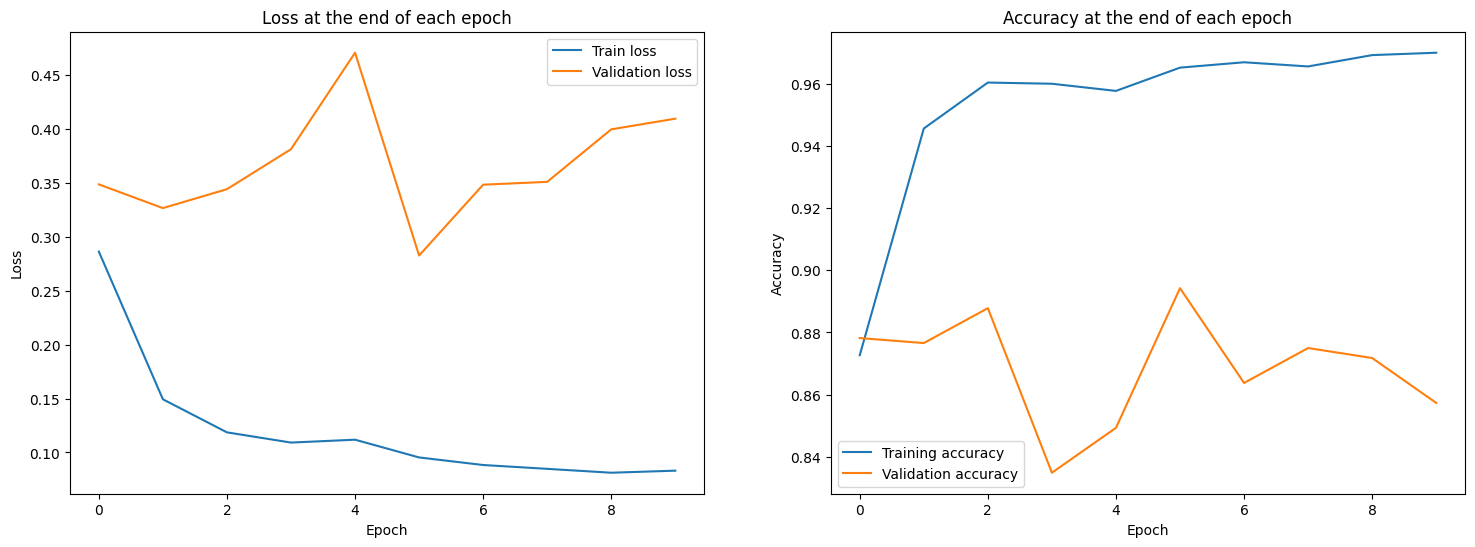

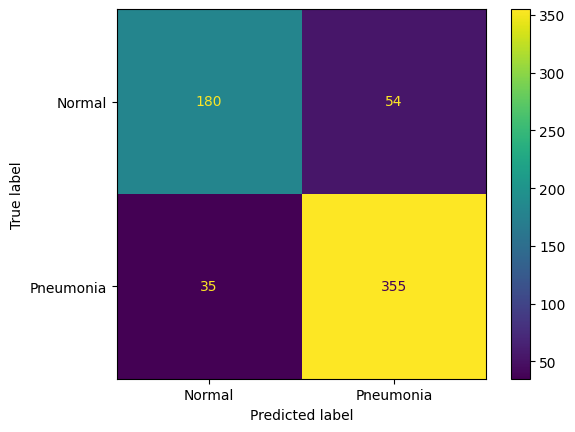

In [12]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_balance, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 3. Add Dropout
Dropout is a regularization technique used in deep learning models to improve generalization and prevent overfitting, especially used in CNN's. During training, a dropout layer randomly 'drops', or deactivates, a portion of the neuron's in the layer it's applied to. For example, if the dropout rate is set to 0.2, then 20% of the neurons in that layer are randomly ignored during each training step. This way, the network is prevented to rely too heavily on specific neurons, promoting redundancy and making the model more robust.

So, lets try to add a dropout layer right after the last convolutional layer, before entering the fully connected layer. And let's set the dropout rate to 0.5

### Model setup

In [13]:
model_dropout = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=learning_rate)

# print the model summary
summary(model_dropout,input_size=[batch_size,n_channels,img_size,img_size])


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model

In [14]:
metrics_history = train_model(model_dropout,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:28<00:00,  2.75s/it]


  Average train loss:0.297044  
 Accuracy on the train dataset: 87.35%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.471603  
 Accuracy on the validation dataset: 77.40%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:34<00:00,  2.79s/it]


  Average train loss:0.171692  
 Accuracy on the train dataset: 93.33%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.377903  
 Accuracy on the validation dataset: 86.54%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:17<00:00,  2.68s/it]


  Average train loss:0.150785  
 Accuracy on the train dataset: 94.90%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.354692  
 Accuracy on the validation dataset: 86.86%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:13<00:00,  2.66s/it]


  Average train loss:0.145775  
 Accuracy on the train dataset: 94.59%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.287475  
 Accuracy on the validation dataset: 89.10%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:15<00:00,  2.67s/it]


  Average train loss:0.116603  
 Accuracy on the train dataset: 95.32%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.320850  
 Accuracy on the validation dataset: 89.10%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:13<00:00,  2.66s/it]


  Average train loss:0.118369  
 Accuracy on the train dataset: 95.32%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


  Average val loss:0.357894  
 Accuracy on the validation dataset: 86.70%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:09<00:00,  2.63s/it]


  Average train loss:0.126776  
 Accuracy on the train dataset: 95.19%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.316181  
 Accuracy on the validation dataset: 88.14%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:21<00:00,  2.71s/it]


  Average train loss:0.110046  
 Accuracy on the train dataset: 95.80%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.357910  
 Accuracy on the validation dataset: 87.18%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:09<00:00,  2.64s/it]


  Average train loss:0.115398  
 Accuracy on the train dataset: 95.80%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


  Average val loss:0.373473  
 Accuracy on the validation dataset: 88.62%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:09<00:00,  2.63s/it]


  Average train loss:0.104326  
 Accuracy on the train dataset: 96.11%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

  Average val loss:0.277583  
 Accuracy on the validation dataset: 88.46%
Done!


### Save the model

In [15]:
torch.save(model_dropout,'../models/simplecnn_dropout_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Accuracy on the test set: 88.46%
Precision: 0.91, Recall: 0.91, F1 score: 0.91, AUC: 0.88
classification_report :              precision    recall  f1-score   support

           0       0.84      0.85      0.85       234
           1       0.91      0.91      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



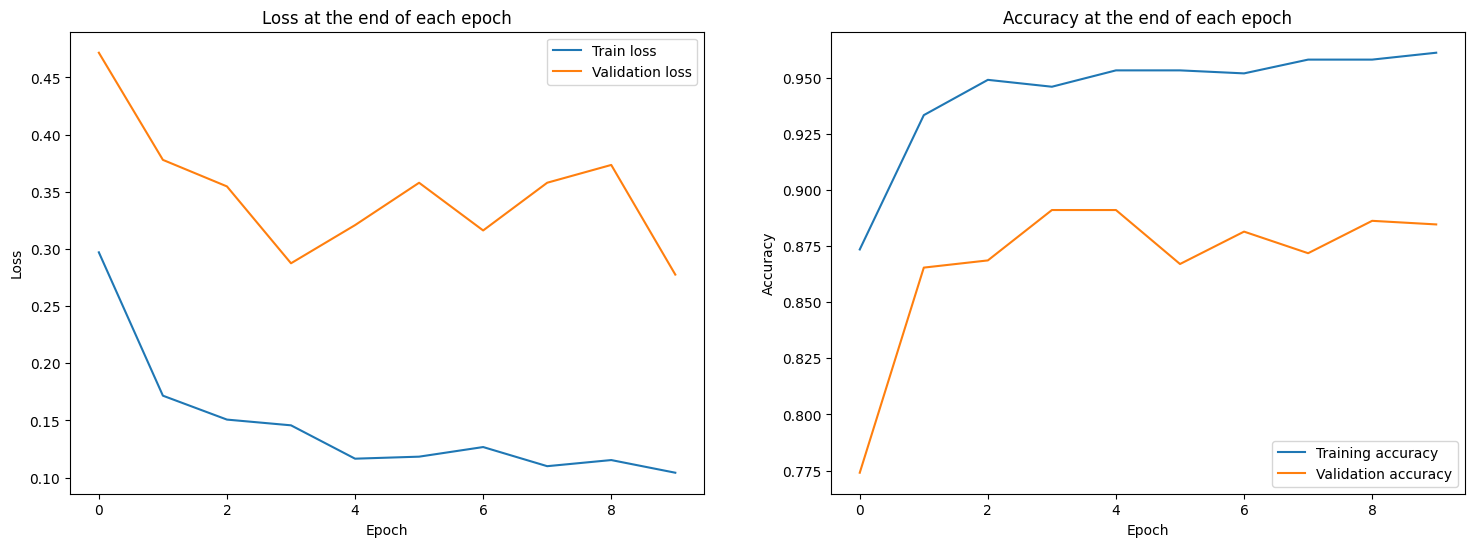

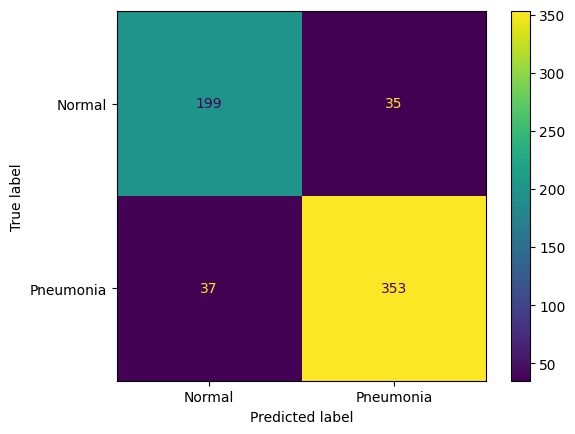

In [16]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_dropout, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])


## 4. Add batch normalization
Deep networks can experience internal convariance shift. This means that the distribution of inputs to each layer changes during training, which forces the network to constantly adapt, and this can slow down training. Batch normalization normalizes the inputs to each layer, which ensures a more stable and faster convergence. Batchnormalization works best when it is placed after a convulutional layer but before the activation function. This allows the network to stabilize its inputs while still allowing the non-linear transformation to take place effectively.
Let's see if batchnormalization can improve our relatively simple model!

### Model setup

In [17]:
model_batchnorm = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model_batchnorm.parameters(), lr=learning_rate)

# print the model summary
summary(model_batchnorm,input_size=[batch_size,n_channels,img_size,img_size])


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

### Train the model


In [18]:
metrics_history = train_model(model_batchnorm,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [08:09<00:00,  3.01s/it]


  Average train loss:0.500949  
 Accuracy on the train dataset: 87.31%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.329711  
 Accuracy on the validation dataset: 86.38%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [08:01<00:00,  2.95s/it]


  Average train loss:0.204889  
 Accuracy on the train dataset: 92.60%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


  Average val loss:0.359497  
 Accuracy on the validation dataset: 88.14%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:53<00:00,  2.90s/it]


  Average train loss:0.192610  
 Accuracy on the train dataset: 92.79%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


  Average val loss:0.411376  
 Accuracy on the validation dataset: 82.69%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


  Average train loss:0.171937  
 Accuracy on the train dataset: 93.46%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


  Average val loss:0.464260  
 Accuracy on the validation dataset: 85.74%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:45<00:00,  2.86s/it]


  Average train loss:0.165588  
 Accuracy on the train dataset: 93.77%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


  Average val loss:0.351212  
 Accuracy on the validation dataset: 86.22%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:51<00:00,  2.90s/it]


  Average train loss:0.156136  
 Accuracy on the train dataset: 93.94%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


  Average val loss:0.394125  
 Accuracy on the validation dataset: 86.22%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:44<00:00,  2.85s/it]


  Average train loss:0.160753  
 Accuracy on the train dataset: 94.17%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.414290  
 Accuracy on the validation dataset: 87.66%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:52<00:00,  2.90s/it]


  Average train loss:0.150085  
 Accuracy on the train dataset: 94.77%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.330067  
 Accuracy on the validation dataset: 88.30%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:37<00:00,  2.81s/it]


  Average train loss:0.132603  
 Accuracy on the train dataset: 94.96%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.447831  
 Accuracy on the validation dataset: 85.58%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:34<00:00,  2.79s/it]


  Average train loss:0.143587  
 Accuracy on the train dataset: 95.05%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]

  Average val loss:0.296055  
 Accuracy on the validation dataset: 89.74%
Done!


### Save the model

In [19]:
torch.save(model_batchnorm,'../models/simplecnn_batchnorm_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Accuracy on the test set: 89.74%
Precision: 0.93, Recall: 0.91, F1 score: 0.92, AUC: 0.89
classification_report :              precision    recall  f1-score   support

           0       0.85      0.88      0.87       234
           1       0.93      0.91      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



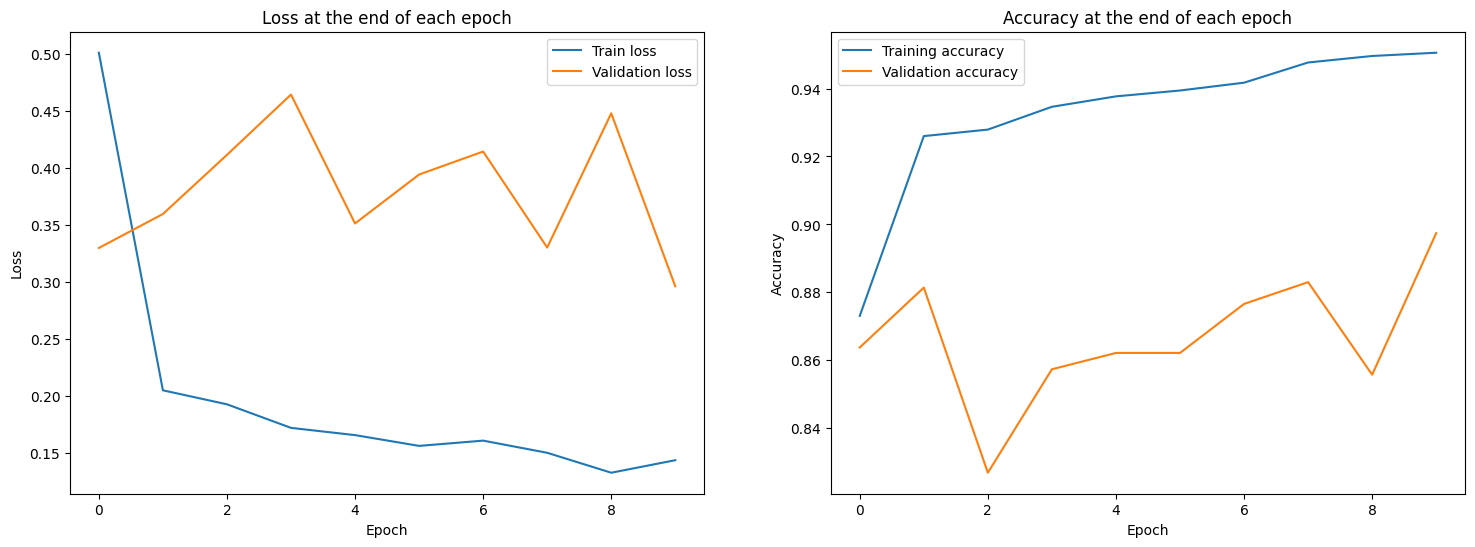

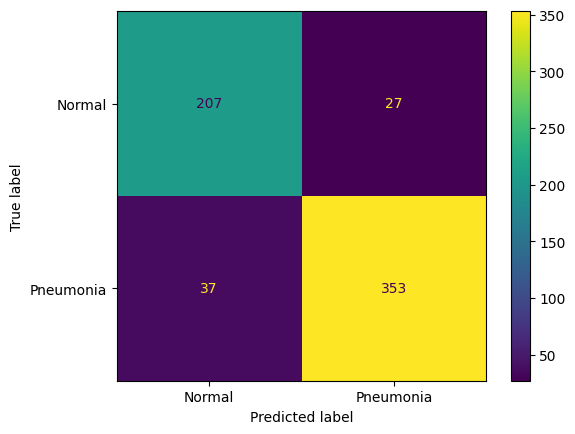

In [20]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_batchnorm, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 5. Add weight decay (L2)
This penalizes larger weights in the model, thereby applying regularization. Weight decay is implemented via the weight_decay parameter in the optimizer
### model setup

In [21]:
### model setup
model_weightdecay = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_weightdecay.parameters(), lr=learning_rate,weight_decay=1e-4)

# print the model summary
summary(model_weightdecay,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

In [22]:
metrics_history = train_model(model_weightdecay,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:49<00:00,  2.88s/it]


  Average train loss:0.480800  
 Accuracy on the train dataset: 87.19%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.406803  
 Accuracy on the validation dataset: 84.78%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:49<00:00,  2.88s/it]


  Average train loss:0.192995  
 Accuracy on the train dataset: 92.85%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


  Average val loss:0.296781  
 Accuracy on the validation dataset: 87.34%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:50<00:00,  2.89s/it]


  Average train loss:0.194481  
 Accuracy on the train dataset: 92.94%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.344080  
 Accuracy on the validation dataset: 84.78%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:27<00:00,  2.75s/it]


  Average train loss:0.160947  
 Accuracy on the train dataset: 94.15%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


  Average val loss:0.321949  
 Accuracy on the validation dataset: 87.82%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


  Average train loss:0.150294  
 Accuracy on the train dataset: 94.31%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.316897  
 Accuracy on the validation dataset: 88.14%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:38<00:00,  2.81s/it]


  Average train loss:0.157196  
 Accuracy on the train dataset: 93.63%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.305408  
 Accuracy on the validation dataset: 85.26%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:36<00:00,  2.80s/it]


  Average train loss:0.155680  
 Accuracy on the train dataset: 93.98%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


  Average val loss:0.315850  
 Accuracy on the validation dataset: 87.18%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:47<00:00,  2.87s/it]


  Average train loss:0.136395  
 Accuracy on the train dataset: 94.96%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.297810  
 Accuracy on the validation dataset: 87.34%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:37<00:00,  2.80s/it]


  Average train loss:0.136956  
 Accuracy on the train dataset: 94.69%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.377338  
 Accuracy on the validation dataset: 85.58%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:43<00:00,  2.84s/it]


  Average train loss:0.135622  
 Accuracy on the train dataset: 95.02%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

  Average val loss:0.298041  
 Accuracy on the validation dataset: 87.66%
Done!


### Save the model

In [23]:
torch.save(model_weightdecay,'../models/simplecnn_weightdecay_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Accuracy on the test set: 87.66%
Precision: 0.91, Recall: 0.89, F1 score: 0.90, AUC: 0.87
classification_report :              precision    recall  f1-score   support

           0       0.82      0.85      0.84       234
           1       0.91      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



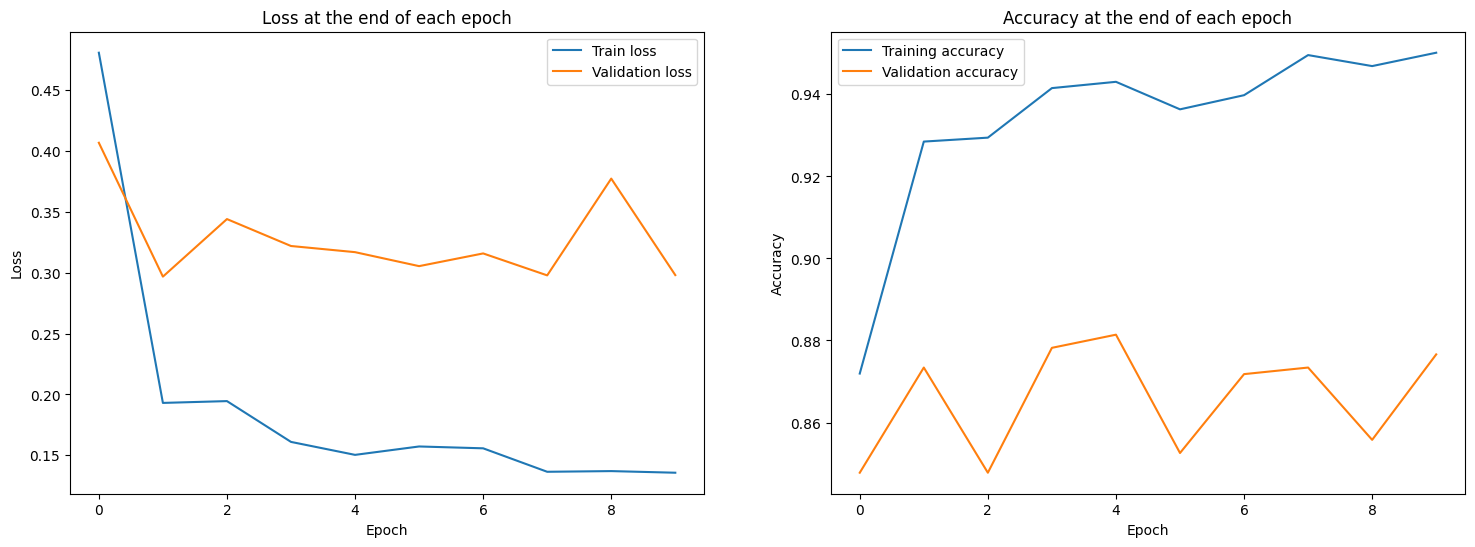

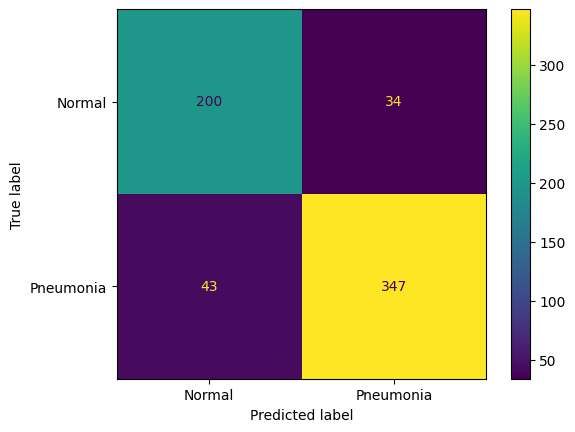

In [24]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_weightdecay, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 6. Learning rate scheduler
A learing rate scheduler can be used to dynamically adjust the learning rate during training. The learning rate will be large early in the training, while it will decrease later in the training to achieve a fine fit.
Here we use Pytorch's CosineAnnealingLR scheduler, which adjusts the learning rate following a cosine curve. This scheduler enables a smooth transition between high and low learning rates throughout the training.

### Model setup

In [25]:
model_scheduler = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_scheduler.parameters(), lr=learning_rate,weight_decay=1e-4)

# scheduler 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=learning_rate*0.1)
# print the model summary
summary(model_scheduler,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

### Train the model

In [26]:
metrics_history = train_model(model_scheduler,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:55<00:00,  2.92s/it]


  Average train loss:0.362318  
 Accuracy on the train dataset: 89.03%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


  Average val loss:0.315087  
 Accuracy on the validation dataset: 87.50%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:46<00:00,  2.86s/it]


  Average train loss:0.198438  
 Accuracy on the train dataset: 92.18%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


  Average val loss:0.364149  
 Accuracy on the validation dataset: 83.97%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:40<00:00,  2.82s/it]


  Average train loss:0.186924  
 Accuracy on the train dataset: 92.62%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.315356  
 Accuracy on the validation dataset: 88.62%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:37<00:00,  2.81s/it]


  Average train loss:0.158773  
 Accuracy on the train dataset: 93.98%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.337981  
 Accuracy on the validation dataset: 86.86%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:33<00:00,  2.78s/it]


  Average train loss:0.131672  
 Accuracy on the train dataset: 94.86%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.318410  
 Accuracy on the validation dataset: 87.18%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:49<00:00,  2.88s/it]


  Average train loss:0.134063  
 Accuracy on the train dataset: 94.86%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.292047  
 Accuracy on the validation dataset: 87.02%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:48<00:00,  2.87s/it]


  Average train loss:0.129626  
 Accuracy on the train dataset: 95.26%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


  Average val loss:0.328041  
 Accuracy on the validation dataset: 87.18%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:47<00:00,  2.87s/it]


  Average train loss:0.119508  
 Accuracy on the train dataset: 95.49%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.347892  
 Accuracy on the validation dataset: 86.86%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:44<00:00,  2.85s/it]


  Average train loss:0.117980  
 Accuracy on the train dataset: 95.99%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.306036  
 Accuracy on the validation dataset: 88.78%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:36<00:00,  2.80s/it]


  Average train loss:0.099327  
 Accuracy on the train dataset: 96.51%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]

  Average val loss:0.374722  
 Accuracy on the validation dataset: 87.66%
Done!


### Save the model

In [27]:
torch.save(model_scheduler,'../models/simplecnn_scheduler_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Accuracy on the test set: 87.66%
Precision: 0.86, Recall: 0.96, F1 score: 0.91, AUC: 0.85
classification_report :              precision    recall  f1-score   support

           0       0.92      0.73      0.82       234
           1       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



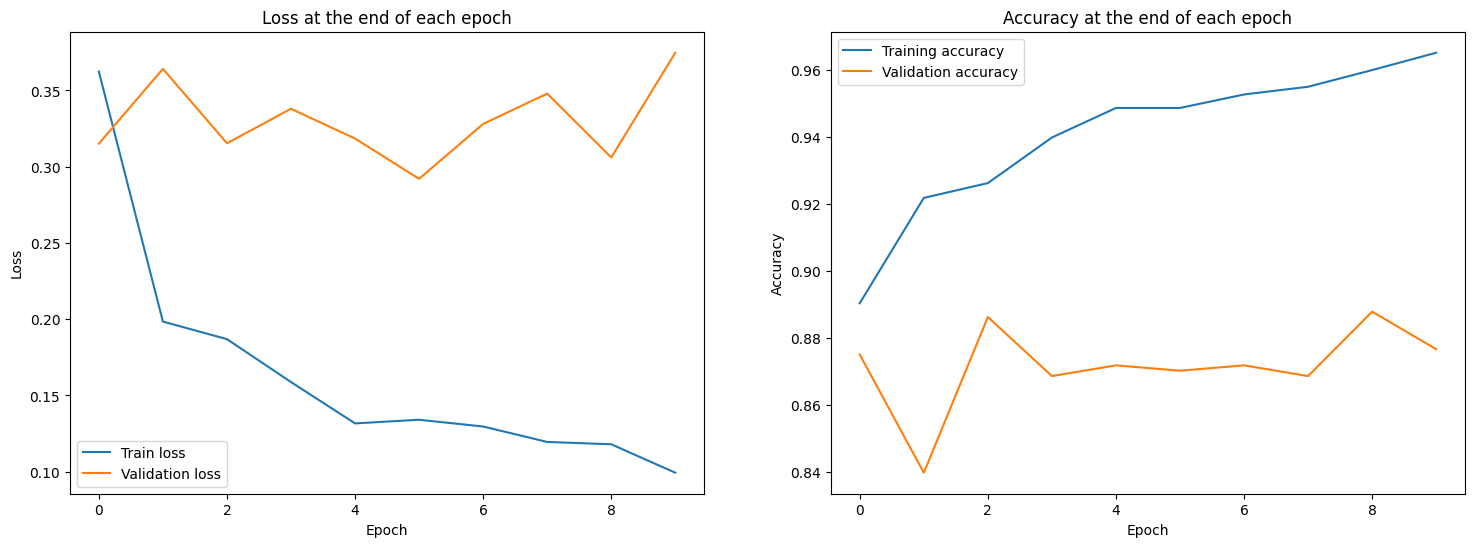

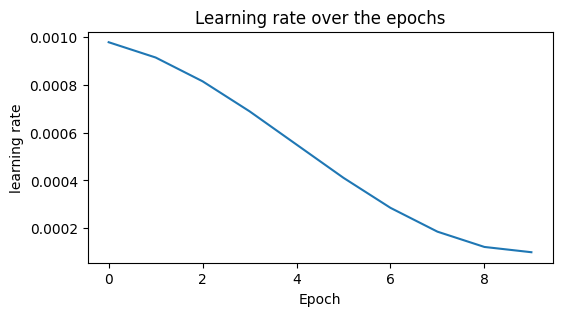

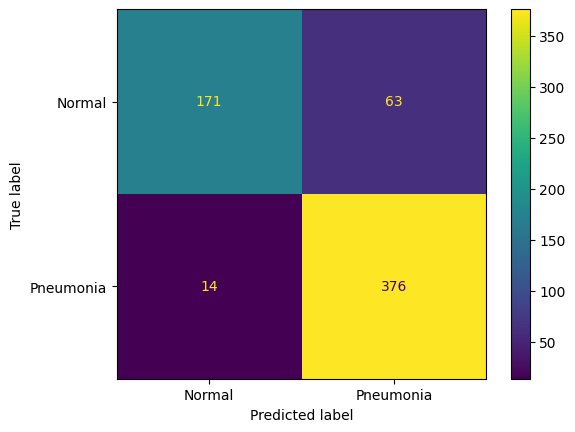

In [28]:
plot_learningcurve(metrics_history)

plot_learningrate(metrics_history['lrs'])

eval_metrics = evaluate_model(model_scheduler, test_dataloader, loss_function, device="cpu")


print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])


## 7. Reduce model size by global average pooling
Our simple CNN already has few layers but another possibility to further reduce complexity is to replease the fully connected layer at the end of our model (Flatten -> Linear) with global average poolding layer + a linear layer (Linear(64,1)). This reduces the number of parameters 
### Model setup

In [29]:
model_reduced = simplecnn.get_simplecnnreduced(n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_reduced.parameters(), lr=learning_rate,weight_decay=1e-4)

# scheduler 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=learning_rate*0.1)
# print the model summary
summary(model_reduced,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNNReduced                         [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

### Train model

In [30]:
metrics_history = train_model(model_reduced,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [07:30<00:00,  2.77s/it]


  Average train loss:0.454548  
 Accuracy on the train dataset: 82.04%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.497750  
 Accuracy on the validation dataset: 81.41%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:26<00:00,  2.74s/it]


  Average train loss:0.392812  
 Accuracy on the train dataset: 85.07%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


  Average val loss:0.491356  
 Accuracy on the validation dataset: 81.73%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:40<00:00,  2.83s/it]


  Average train loss:0.375761  
 Accuracy on the train dataset: 85.16%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


  Average val loss:0.549079  
 Accuracy on the validation dataset: 76.76%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:22<00:00,  2.71s/it]


  Average train loss:0.356455  
 Accuracy on the train dataset: 86.37%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.426142  
 Accuracy on the validation dataset: 82.37%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:31<00:00,  2.77s/it]


  Average train loss:0.318292  
 Accuracy on the train dataset: 88.46%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.394630  
 Accuracy on the validation dataset: 82.85%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:20<00:00,  2.71s/it]


  Average train loss:0.327147  
 Accuracy on the train dataset: 87.48%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


  Average val loss:0.433551  
 Accuracy on the validation dataset: 84.13%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:32<00:00,  2.78s/it]


  Average train loss:0.312535  
 Accuracy on the train dataset: 87.46%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


  Average val loss:0.554826  
 Accuracy on the validation dataset: 76.28%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:58<00:00,  2.93s/it]


  Average train loss:0.296443  
 Accuracy on the train dataset: 88.82%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.374391  
 Accuracy on the validation dataset: 84.13%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:40<00:00,  2.82s/it]


  Average train loss:0.279838  
 Accuracy on the train dataset: 89.86%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.412126  
 Accuracy on the validation dataset: 83.65%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


  Average train loss:0.273925  
 Accuracy on the train dataset: 89.65%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

  Average val loss:0.356449  
 Accuracy on the validation dataset: 85.74%
Done!


### Save the model

In [31]:
torch.save(model_reduced,'../models/simplecnn_reduced_10ep.tph')

Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Accuracy on the test set: 85.74%
Precision: 0.88, Recall: 0.89, F1 score: 0.89, AUC: 0.85
classification_report :              precision    recall  f1-score   support

           0       0.82      0.80      0.81       234
           1       0.88      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



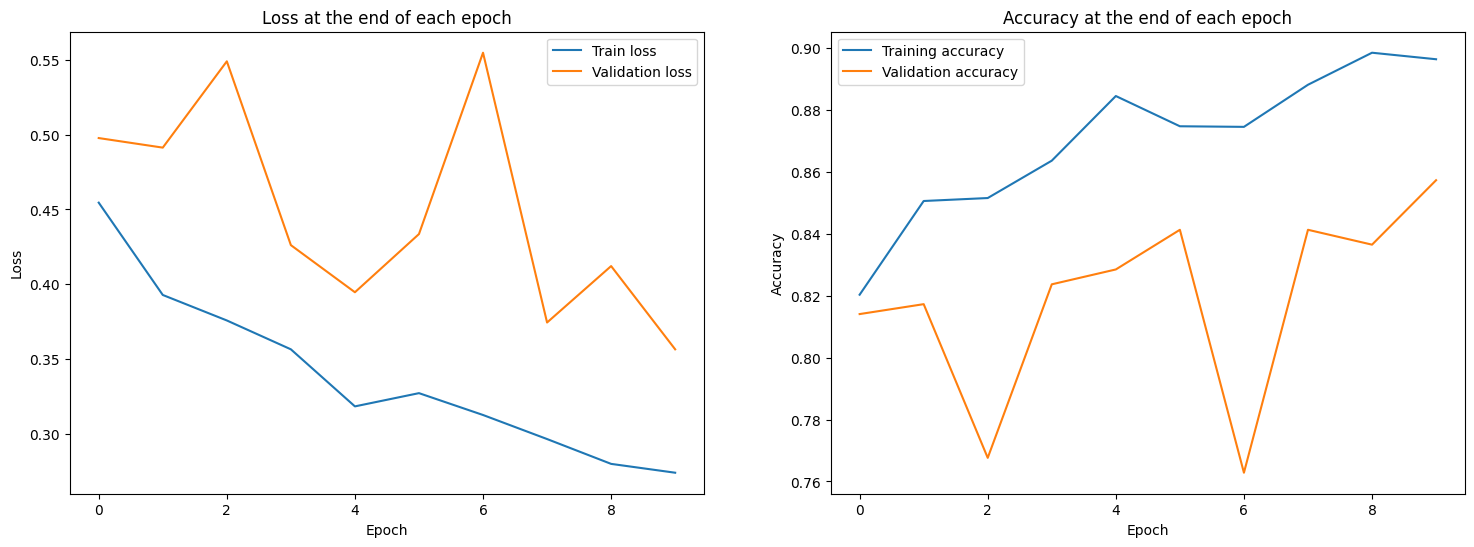

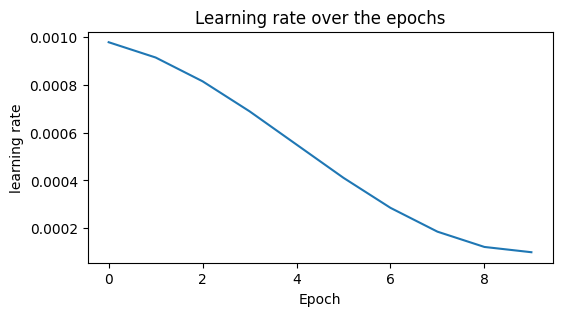

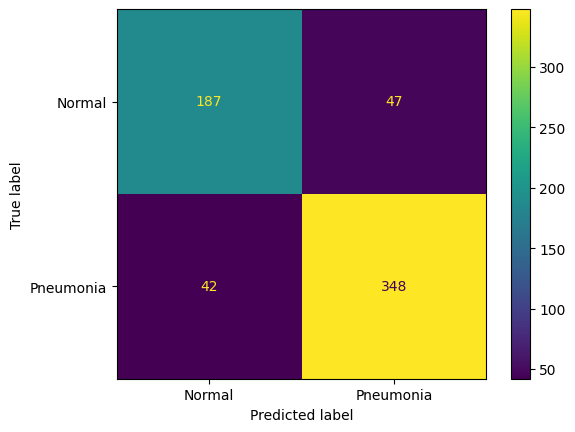

In [32]:
plot_learningcurve(metrics_history)
plot_learningrate(metrics_history['lrs'])
eval_metrics = evaluate_model(model_reduced, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])